In [1]:
!pip install rioxarray geopy planetary_computer pystac_client geopandas shapely odc-stac nb_black

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%cd drive/MyDrive/algea

%load_ext lab_black
%load_ext autoreload
%autoreload 2

/content/drive/MyDrive/algea


In [3]:
import cv2
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import odc.stac
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import os
import geopandas as gpd
from shapely.geometry import Point

# Establish a connection to the STAC API
import planetary_computer as pc
from pystac_client import Client
import geopy.distance as distance

import rioxarray
from IPython.display import Image
from PIL import Image as PILImage

%matplotlib inline

In [4]:
DATA_DIR = os.path.join(Path.cwd().resolve(), "data")

metadata = pd.read_csv(DATA_DIR + '/tables/metadata.csv')
train_labels = pd.read_csv(DATA_DIR + '/tables/train_labels.csv')
submission = pd.read_csv(DATA_DIR + '/tables/submission_format.csv', index_col=0)

In [63]:
train_labels

,uid,region,severity,density
0,aabm,midwest,1,585.0
1,aacd,south,1,290.0
2,aaee,south,1,1614.0
3,aaff,midwest,3,111825.0
4,aafl,midwest,4,2017313.0
...,...,...,...,...
17055,zzsv,south,3,113125.0
17056,zzuq,south,3,175726.0
17057,zzwo,midwest,2,48510.0
17058,zzwq,south,1,1271.0


In [65]:
metadata[metadata['split'] == 'train'].merge(train_labels[['uid', 'region']], on='uid', how='left')

,uid,latitude,longitude,date,split,region
0,aabm,39.080319,-86.430867,2018-05-14,train,midwest
1,aacd,35.875083,-78.878434,2020-11-19,train,south
2,aaee,35.487000,-79.062133,2016-08-24,train,south
3,aaff,38.049471,-99.827001,2019-07-23,train,midwest
4,aafl,39.474744,-86.898353,2021-08-23,train,midwest
...,...,...,...,...,...,...
17055,zzsv,38.707825,-75.080867,2018-06-27,train,south
17056,zzuq,35.794000,-79.015368,2015-08-06,train,south
17057,zzwo,39.792190,-99.971050,2017-06-19,train,midwest
17058,zzwq,35.794000,-79.012551,2015-03-24,train,south


# Process Feature Data

In [5]:
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace
)

# Pulling One Sample

In [6]:
example_row = metadata[metadata.uid == "garm"].iloc[0]
example_row

uid                garm
latitude       41.98006
longitude    -110.65734
date         2021-09-27
split             train
Name: 5461, dtype: object

In [7]:
# get our bounding box to search latitude and longitude coordinates
def get_bounding_box(latitude, longitude, meter_buffer=50000):
    """
    Given a latitude, longitude, and buffer in meters, returns a bounding
    box around the point with the buffer on the left, right, top, and bottom.

    Returns a list of [minx, miny, maxx, maxy]
    """
    distance_search = distance.distance(meters=meter_buffer)

    # calculate the lat/long bounds based on ground distance
    # bearings are cardinal directions to move (south, west, north, and east)
    min_lat = distance_search.destination((latitude, longitude), bearing=180)[0]
    min_long = distance_search.destination((latitude, longitude), bearing=270)[1]
    max_lat = distance_search.destination((latitude, longitude), bearing=0)[0]
    max_long = distance_search.destination((latitude, longitude), bearing=90)[1]

    return [min_long, min_lat, max_long, max_lat]

# get our date range to search, and format correctly for query
def get_date_range(date, time_buffer_days=15):
    """Get a date range to search for in the planetary computer based
    on a sample's date. The time range will include the sample date
    and time_buffer_days days prior

    Returns a string"""
    datetime_format = "%Y-%m-%d"
    range_start = pd.to_datetime(date) - timedelta(days=time_buffer_days)
    date_range = f"{range_start.strftime(datetime_format)}/{pd.to_datetime(date).strftime(datetime_format)}"

    return date_range

In [8]:
bbox = get_bounding_box(example_row.latitude, example_row.longitude, meter_buffer=50000)
print(bbox)
date_range = get_date_range(example_row.date)
date_range

[-111.26063646639783, 41.52988747516146, -110.05404353360218, 42.43019710235757]


'2021-09-12/2021-09-27'

In [9]:
# search the planetary computer sentinel-l2a and landsat level-2 collections
search = catalog.search(
    collections=["sentinel-2-l2a", "landsat-c2-l2"], bbox=bbox, datetime=date_range
)

# see how many items were returned
items = [item for item in search.get_all_items()]
len(items)

46

In [10]:
# get details of all of the items returned
item_details = pd.DataFrame(
    [
        {
            "datetime": item.datetime.strftime("%Y-%m-%d"),
            "platform": item.properties["platform"],
            "min_long": item.bbox[0],
            "max_long": item.bbox[2],
            "min_lat": item.bbox[1],
            "max_lat": item.bbox[3],
            "bbox": item.bbox,
            "item_obj": item,
        }
        for item in items
    ]
)

# check which rows actually contain the sample location
item_details["contains_sample_point"] = (
    (item_details.min_lat < example_row.latitude)
    & (item_details.max_lat > example_row.latitude)
    & (item_details.min_long < example_row.longitude)
    & (item_details.max_long > example_row.longitude)
)

print(
    f"Filtering from {len(item_details)} returned to {item_details.contains_sample_point.sum()} items that contain the sample location"
)

item_details = item_details[item_details["contains_sample_point"]]
item_details[["datetime", "platform", "contains_sample_point", "bbox"]].sort_values(
    by="datetime"
)    

Filtering from 46 returned to 7 items that contain the sample location


,datetime,platform,contains_sample_point,bbox
44,2021-09-12,landsat-8,True,"[-111.34023745, 40.67702495, -108.51528663, 42..."
34,2021-09-14,Sentinel-2A,True,"[-111.000244, 41.45624189757688, -109.665115, ..."
21,2021-09-19,Sentinel-2B,True,"[-111.000244, 41.45624189757688, -109.665115, ..."
26,2021-09-19,landsat-8,True,"[-112.92522743, 40.67353498, -110.06644659, 42..."
18,2021-09-20,landsat-7,True,"[-111.60018779, 40.80284495, -108.59831681, 42..."
8,2021-09-24,Sentinel-2A,True,"[-111.000244, 41.4562419, -109.665115, 42.4526..."
5,2021-09-27,landsat-7,True,"[-113.18385774, 40.78803499, -110.15150674, 42..."


In [11]:
# 1 - filter to sentinel
item_details[item_details.platform.str.contains("Sentinel")]

,datetime,platform,min_long,max_long,min_lat,max_lat,bbox,item_obj,contains_sample_point
8,2021-09-24,Sentinel-2A,-111.000244,-109.665115,41.456242,42.452691,"[-111.000244, 41.4562419, -109.665115, 42.4526...",<Item id=S2A_MSIL2A_20210924T181101_R084_T12TW...,True
21,2021-09-19,Sentinel-2B,-111.000244,-109.665115,41.456242,42.452691,"[-111.000244, 41.45624189757688, -109.665115, ...",<Item id=S2B_MSIL2A_20210919T180919_R084_T12TW...,True
34,2021-09-14,Sentinel-2A,-111.000244,-109.665115,41.456242,42.452691,"[-111.000244, 41.45624189757688, -109.665115, ...",<Item id=S2A_MSIL2A_20210914T180951_R084_T12TW...,True


In [12]:
# 2 - take closest by date
best_item = (
    item_details[item_details.platform.str.contains("Sentinel")]
    .sort_values(by="datetime", ascending=False)
    .iloc[0]
)
best_item

datetime                                                        2021-09-24
platform                                                       Sentinel-2A
min_long                                                       -111.000244
max_long                                                       -109.665115
min_lat                                                          41.456242
max_lat                                                          42.452691
bbox                     [-111.000244, 41.4562419, -109.665115, 42.4526...
item_obj                 <Item id=S2A_MSIL2A_20210924T181101_R084_T12TW...
contains_sample_point                                                 True
Name: 8, dtype: object

In [13]:
item = best_item.item_obj

# What assets are available?
for asset_key, asset in item.assets.items():
    print(f"{asset_key:<25} - {asset.title}")

AOT                       - Aerosol optical thickness (AOT)
B01                       - Band 1 - Coastal aerosol - 60m
B02                       - Band 2 - Blue - 10m
B03                       - Band 3 - Green - 10m
B04                       - Band 4 - Red - 10m
B05                       - Band 5 - Vegetation red edge 1 - 20m
B06                       - Band 6 - Vegetation red edge 2 - 20m
B07                       - Band 7 - Vegetation red edge 3 - 20m
B08                       - Band 8 - NIR - 10m
B09                       - Band 9 - Water vapor - 60m
B11                       - Band 11 - SWIR (1.6) - 20m
B12                       - Band 12 - SWIR (2.2) - 20m
B8A                       - Band 8A - Vegetation red edge 4 - 20m
SCL                       - Scene classfication map (SCL)
WVP                       - Water vapour (WVP)
visual                    - True color image
preview                   - Thumbnail
safe-manifest             - SAFE manifest
granule-metadata          - Granul

In [14]:
# see the whole image
img = Image(url=item.assets["rendered_preview"].href, width=500)

Image(url=item.assets["rendered_preview"].href, width=500)

In [15]:
def crop_sentinel_image(item, bounding_box):
    """
    Given a STAC item from Sentinel-2 and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box

    image = rioxarray.open_rasterio(pc.sign(item.assets["visual"].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    )

    return image.to_numpy()

In [16]:
# get a smaller geographic bounding box
minx, miny, maxx, maxy = get_bounding_box(
    example_row.latitude, example_row.longitude, meter_buffer=3000
)

# get the zoomed in image array
bbox = (minx, miny, maxx, maxy)
zoomed_img_array = crop_sentinel_image(item, bbox)

zoomed_img_array[0]

array([[214, 224, 213, ..., 124, 109, 103],
       [215, 220, 201, ..., 114,  95,  94],
       [217, 222, 187, ..., 106,  95,  94],
       ...,
       [223, 185, 193, ..., 112, 118, 120],
       [181, 140, 190, ..., 110, 111, 117],
       [134, 125, 185, ..., 107, 107, 111]], dtype=uint8)

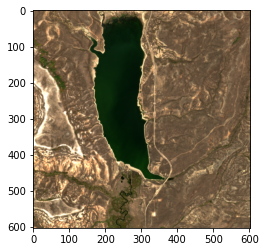

In [17]:
# we have to transpose some of the dimensions to plot
# matplotlib expects channels in a certain order
plt.imshow(np.transpose(zoomed_img_array, axes=[1, 2, 0]))

# Visualizing Landsat imagery

In [18]:
landsat_item = (
    item_details[item_details.platform.str.contains("landsat")]
    .sample(n=1, random_state=3)
    .iloc[0]
)
landsat_item

datetime                                                        2021-09-12
platform                                                         landsat-8
min_long                                                       -111.340237
max_long                                                       -108.515287
min_lat                                                          40.677025
max_lat                                                          42.817595
bbox                     [-111.34023745, 40.67702495, -108.51528663, 42...
item_obj                         <Item id=LC08_L2SP_037031_20210912_02_T1>
contains_sample_point                                                 True
Name: 44, dtype: object

In [19]:
def crop_landsat_image(item, bounding_box):
    """
    Given a STAC item from Landsat and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box

    image = odc.stac.stac_load(
        [pc.sign(item)], bands=["red", "green", "blue"], bbox=[minx, miny, maxx, maxy]
    ).isel(time=0)
    image_array = image[["red", "green", "blue"]].to_array().to_numpy()

    # normalize to 0 - 255 values
    image_array = cv2.normalize(image_array, None, 0, 255, cv2.NORM_MINMAX)

    return image_array

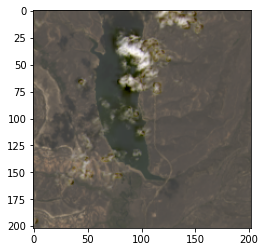

In [20]:
item = landsat_item.item_obj

# we'll use the same cropped area as above
landsat_image_array = crop_landsat_image(item, bbox)
landsat_image_array[0]
plt.imshow(np.transpose(landsat_image_array, axes=[1, 2, 0]))

In [21]:
# load image but don't convert to numpy or rescale
image = odc.stac.stac_load(
    [pc.sign(item)], bands=["red", "green", "blue"], bbox=bbox
).isel(time=0)
image_array = image[["red", "green", "blue"]].to_array()

# values are not scaled 0 - 255 when first returned
image_array[0]

<xarray.DataArray (y: 202, x: 202)>
array([[12933, 13488, 11722, ..., 10544, 10770, 10988],
       [13164, 13673, 11810, ..., 10660, 11079, 10844],
       [13250, 13085, 11760, ..., 11094, 11137, 10551],
       ...,
       [13158, 12414, 11900, ..., 11263, 11087, 11157],
       [11882, 11630, 11493, ..., 11082, 10912, 10931],
       [14101, 13137, 12880, ..., 10945, 10871, 11113]], dtype=uint16)
Coordinates:
  * y            (y) float64 4.651e+06 4.651e+06 ... 4.645e+06 4.645e+06
  * x            (x) float64 5.254e+05 5.254e+05 ... 5.314e+05 5.314e+05
    spatial_ref  int32 32612
    time         datetime64[ns] 2021-09-12T18:01:53.979983
    variable     <U3 'red'

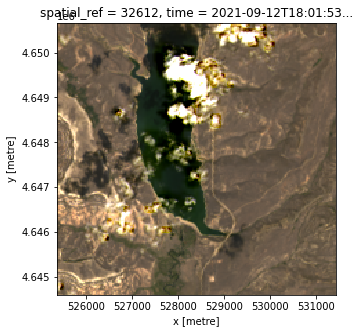

In [22]:
# image appears differently without rescaling
fig, ax = plt.subplots(figsize=(5, 5))
image_array.plot.imshow(robust=True, ax=ax)

# Convert imagery to features

In [23]:
# define a small area to crop around
# crop to 400 meters squared around the sampling point
minx, miny, maxx, maxy = get_bounding_box(
    example_row.latitude, example_row.longitude, meter_buffer=100
)
minx, miny, maxx, maxy

(-110.65854661288282,
 41.97915969028358,
 -110.6561333871172,
 41.980960309574755)

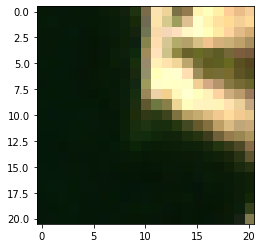

In [24]:
bbox = (minx, miny, maxx, maxy)
feature_image_array = crop_sentinel_image(best_item.item_obj, bounding_box=bbox)

plt.imshow(np.transpose(feature_image_array, axes=[1, 2, 0]))

In [25]:
type(feature_image_array), feature_image_array.shape

(numpy.ndarray, (3, 21, 21))

In [26]:
# take the average over the second and third dimensions
image_color_averages = feature_image_array.mean(axis=(1, 2)).tolist()

# also take the median
image_color_medians = np.median(feature_image_array, axis=(1, 2)).tolist()

# concatenate the two lists
image_features = image_color_averages + image_color_medians
image_features

[64.1156462585034, 71.21541950113378, 42.44897959183673, 8.0, 26.0, 9.0]

# REFACTOR AND RUN ON ALL TRAINING DATA

In [27]:
# Refactor our process from above into functions
def select_best_item(items, date, latitude, longitude):
    """
    Select the best satellite item given a sample's date, latitude, and longitude.
    If any Sentinel-2 imagery is available, returns the closest sentinel-2 image by
    time. Otherwise, returns the closest Landsat imagery.

    Returns a tuple of (STAC item, item platform name, item date)
    """
    # get item details
    item_details = pd.DataFrame(
        [
            {
                "datetime": item.datetime.strftime("%Y-%m-%d"),
                "platform": item.properties["platform"],
                "min_long": item.bbox[0],
                "max_long": item.bbox[2],
                "min_lat": item.bbox[1],
                "max_lat": item.bbox[3],
                "item_obj": item,
            }
            for item in items
        ]
    )

    # filter to items that contain the point location, or return None if none contain the point
    item_details["contains_sample_point"] = (
        (item_details.min_lat < latitude)
        & (item_details.max_lat > latitude)
        & (item_details.min_long < longitude)
        & (item_details.max_long > longitude)
    )
    item_details = item_details[item_details["contains_sample_point"] == True]
    if len(item_details) == 0:
        return (np.nan, np.nan, np.nan)

    # add time difference between each item and the sample
    item_details["time_diff"] = pd.to_datetime(date) - pd.to_datetime(
        item_details["datetime"]
    )

    # if we have sentinel-2, filter to sentinel-2 images only
    item_details["sentinel"] = item_details.platform.str.lower().str.contains(
        "sentinel"
    )
    if item_details["sentinel"].any():
        item_details = item_details[item_details["sentinel"] == True]

    # return the closest imagery by time
    best_item = item_details.sort_values(by="time_diff", ascending=True).iloc[0]

    return (best_item["item_obj"], best_item["platform"], best_item["datetime"])


def image_to_features(image_array):
    """
    Convert an image array of the form (color band, height, width) to a
    1-dimensional list of features. Returns a list where the first three
    values are the averages of each color band, and the second three
    values are the medians of each color band.
    """
    averages = image_array.mean(axis=(1, 2)).tolist()
    medians = np.median(image_array, axis=(1, 2)).tolist()

    return averages + medians

In [28]:
BENCHMARK_DATA_DIR = DATA_DIR + "/benchmark"

# save image arrays in case we want to generate more features
IMAGE_ARRAY_DIR = BENCHMARK_DATA_DIR + "/image_arrays"


In [29]:
# take a random subset of the training data for the benchmark
train_subset = metadata[metadata["split"] == "train"].sample(n=2500, random_state=2)

# combine train subset with all test data
metadata_subset = pd.concat([train_subset, metadata[metadata["split"] == "test"]])
metadata_subset.split.value_counts(dropna=False)

test     6510
train    2500
Name: split, dtype: int64

In [30]:
# this cell takes a LONG time because it iterates over all data!

# save outputs in dictionaries
selected_items = {}
features_dict = {}
errored_ids = []


for row in tqdm(metadata_subset.itertuples(), total=len(metadata_subset)):
    pass
    # check if we've already saved the selected image array
    image_array_pth = f"{IMAGE_ARRAY_DIR}/{row.uid}.npy"

    if os.path.exists(image_array_pth):
        with open(image_array_pth, "rb") as f:
            image_array = np.load(f)

        # convert image to 1-dimensional features
        image_features = image_to_features(image_array)
        features_dict[row.uid] = image_features

    # search and load the image array if not
    else:
        try:
            ## QUERY STAC API
            # get query ranges for location and date
            search_bbox = get_bounding_box(
                row.latitude, row.longitude, meter_buffer=50000
            )
            date_range = get_date_range(row.date, time_buffer_days=15)

            # search the planetary computer
            search = catalog.search(
                collections=["sentinel-2-l2a", "landsat-c2-l2"],
                bbox=search_bbox,
                datetime=date_range,
            )
            items = [item for item in search.get_all_items()]

            ## GET BEST IMAGE
            if len(items) == 0:
                pass
            else:
                best_item, item_platform, item_date = select_best_item(
                    items, row.date, row.latitude, row.longitude
                )
                # add to dictionary tracking best items
                selected_items[row.uid] = {
                    "item_object": best_item,
                    "item_platform": item_platform,
                    "item_date": item_date,
                }

            ## CONVERT TO FEATURES
            # get small bbox just for features
            feature_bbox = get_bounding_box(
                row.latitude, row.longitude, meter_buffer=100
            )

            # crop the image
            if "sentinel" in item_platform.lower():
                image_array = crop_sentinel_image(best_item, feature_bbox)
            else:
                image_array = crop_landsat_image(best_item, feature_bbox)

            # save image array so we don't have to rerun
            with open(image_array_pth, "wb") as f:
                np.save(f, image_array)

            # convert image to 1-dimensional features
            image_features = image_to_features(image_array)
            features_dict[row.uid] = image_features

        # keep track of any that ran into errors without interrupting the process
        except:
            errored_ids.append(row.uid)

100%|██████████| 9010/9010 [02:14<00:00, 67.06it/s]


In [31]:
# bring features into a dataframe
image_features = pd.DataFrame(features_dict).T
image_features.columns = [
    "red_average",
    "green_average",
    "blue_average",
    "red_median",
    "green_median",
    "blue_median",
]
image_features.head()

,red_average,green_average,blue_average,red_median,green_median,blue_median
umac,26.305195,44.173160,28.357143,25.0,34.0,27.0
egox,0.000000,0.000000,0.000000,0.0,0.0,0.0
havx,0.000000,0.000000,0.000000,0.0,0.0,0.0
laoq,0.000000,0.000000,0.000000,0.0,0.0,0.0
ttsk,24.071429,41.266234,21.489177,23.0,40.0,21.0


In [32]:
# save out our features!
image_features.to_csv(BENCHMARK_DATA_DIR + "/image_features.csv", index=True)

In [33]:
# bring together train labels and features into one dataframe
# this ensures the features array and labels array will be in same order
train_data = train_labels.merge(
    image_features, how="inner", left_on="uid", right_index=True, validate="1:1"
)

# split into train and validation
rng = np.random.RandomState(30)
train_data["split"] = rng.choice(
    ["train", "validation"], size=len(train_data), replace=True, p=[0.67, 0.33]
)

train_data.head()

,uid,region,severity,density,red_average,green_average,blue_average,red_median,green_median,blue_median,split
4,aafl,midwest,4,2.017313e+06,95.807256,102.832200,74.993197,53.0,71.0,46.0,train
5,aafp,south,1,1.594000e+03,18.410431,25.294785,12.448980,18.0,24.0,12.0,train
20,aarq,northeast,1,1.013300e+04,45.984127,37.170068,15.392290,27.0,27.0,8.0,train
31,aben,south,1,9.730000e+03,127.000000,151.041126,147.158009,105.0,128.0,116.0,train
37,aboc,midwest,1,3.582413e+02,255.000000,255.000000,255.000000,255.0,255.0,255.0,validation


In [34]:
# separate features and labels, and train and validation
feature_cols = [
    "red_average",
    "green_average",
    "blue_average",
    "red_median",
    "green_median",
    "blue_median",
]
target_col = "severity"

val_set_mask = train_data.split == "validation"
X_train = train_data.loc[~val_set_mask, feature_cols].values
y_train = train_data.loc[~val_set_mask, target_col]
X_val = train_data.loc[val_set_mask, feature_cols].values
y_val = train_data.loc[val_set_mask, target_col]

# flatten label data into 1-d arrays
y_train = y_train.values.flatten()
y_val = y_val.values.flatten()

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1622, 6), (856, 6), (1622,), (856,))

In [35]:
# save out features
x_train_pth = BENCHMARK_DATA_DIR + "/x_train.npy"
#x_train_pth.parent.mkdir(exist_ok=True, parents=True)

with open(x_train_pth, "wb") as f:
    np.save(f, X_train)

# save out labels
y_train_pth = BENCHMARK_DATA_DIR + "/y_train.npy"

with open(y_train_pth, "wb") as f:
    np.save(f, y_train)

In [36]:
%%writefile train_gbm_model.py
import lightgbm as lgb

import joblib
import numpy as np
from pathlib import Path
from loguru import logger
import typer

DATA_DIR = Path.cwd() / "data"


def main(
    features_path=DATA_DIR / "benchmark/x_train.npy",
    labels_path=DATA_DIR / "benchmark/y_train.npy",
    model_save_path=DATA_DIR / "benchmark/lgb_classifier.txt",
):
    """
    Train a LightGBM model based on training features in features_path and
    training labels in labels_path. Save our the trained model to model_save_path
    """

    # load saved features and labels
    with open(features_path, "rb") as f:
        X_train = np.load(f)
    with open(labels_path, "rb") as f:
        y_train = np.load(f)

    logger.info(f"Loaded training features of shape {X_train.shape} from {features_path}")
    logger.info(f"Loading training labels of shape {y_train.shape} from {labels_path}")

    # instantiate tree model
    model = lgb.LGBMClassifier(random_state=10)

    # fit model
    logger.info("Fitting LGBM model")
    model.fit(X_train, y_train)
    print(model)

    # save out model weights
    joblib.dump(model, str(model_save_path))
    logger.success(f"Model weights saved to {model_save_path}")


if __name__ == "__main__":
    typer.run(main)


Overwriting train_gbm_model.py


In [37]:
!python train_gbm_model.py

2023-02-10 08:57:04.486 | INFO     | __main__:main:28 - Loaded training features of shape (1622, 6) from /content/drive/MyDrive/algea/data/benchmark/x_train.npy
2023-02-10 08:57:04.486 | INFO     | __main__:main:29 - Loading training labels of shape (1622,) from /content/drive/MyDrive/algea/data/benchmark/y_train.npy
2023-02-10 08:57:04.487 | INFO     | __main__:main:35 - Fitting LGBM model
LGBMClassifier(random_state=10)
2023-02-10 08:57:09.610 | SUCCESS  | __main__:main:41 - Model weights saved to /content/drive/MyDrive/algea/data/benchmark/lgb_classifier.txt


In [38]:
# save out validation features
x_val_pth = BENCHMARK_DATA_DIR + "/x_val.npy"
# x_val_pth.parent.mkdir(exist_ok=True, parents=True)

with open(x_val_pth, "wb") as f:
    np.save(f, X_val)

# save out validation labels
y_val_pth = BENCHMARK_DATA_DIR + "/y_val.npy"

with open(y_val_pth, "wb") as f:
    np.save(f, y_val)

In [39]:
%%writefile predict_gbm_model.py
import lightgbm as lgb

import joblib
from loguru import logger
import numpy as np
from pathlib import Path
import typer

DATA_DIR = Path.cwd() / "data/benchmark"


def main(
    model_weights_path=DATA_DIR / "lgb_classifier.txt",
    features_path=DATA_DIR / "x_val.npy",
    preds_save_path=DATA_DIR / "val_preds.npy",
):
    """
    Generate predictions with a LightGBM model using weights saved at model_weights_path
    and features saved at features_path. Save out predictions to preds_save_path.
    """
    # load model weights
    lgb_model = joblib.load(model_weights_path)
    logger.info(f"Loaded model {lgb_model} from {model_weights_path}")

    # load the features
    with open(features_path, "rb") as f:
        X_val = np.load(f)
    logger.info(f"Loaded features of shape {X_val.shape} from {features_path}")

    # generate predictions
    preds = lgb_model.predict(X_val)

    # save out predictions
    with open(preds_save_path, "wb") as f:
        np.save(f, preds)
    logger.success(f"Predictions saved to {preds_save_path}")


if __name__ == "__main__":
    typer.run(main)

Overwriting predict_gbm_model.py


In [40]:
!python predict_gbm_model.py

2023-02-10 08:57:11.151 | INFO     | __main__:main:23 - Loaded model LGBMClassifier(random_state=10) from /content/drive/MyDrive/algea/data/benchmark/lgb_classifier.txt
2023-02-10 08:57:11.159 | INFO     | __main__:main:28 - Loaded features of shape (856, 6) from /content/drive/MyDrive/algea/data/benchmark/x_val.npy
2023-02-10 08:57:11.187 | SUCCESS  | __main__:main:36 - Predictions saved to /content/drive/MyDrive/algea/data/benchmark/val_preds.npy


In [41]:
preds_pth = BENCHMARK_DATA_DIR + "/val_preds.npy"
with open(preds_pth, "rb") as f:
    val_preds = np.load(f)

In [42]:
pd.Series(val_preds).value_counts().sort_index()

1    601
2     60
3     59
4    136
dtype: int64

In [43]:
# get the validation part of the training data
val_set = train_data[train_data.split == "validation"][
    ["uid", "region", "severity"]
].copy()
val_set["pred"] = val_preds

val_set.head()

,uid,region,severity,pred
37,aboc,midwest,1,1
42,abso,south,2,1
91,aduy,south,2,3
94,adwl,south,1,1
120,afbi,midwest,4,1


In [44]:
region_scores = []
for region in val_set.region.unique():
    sub = val_set[val_set.region == region]
    region_rmse = mean_squared_error(sub.severity, sub.pred, squared=False)
    print(f"RMSE for {region} (n={len(sub)}): {round(region_rmse, 4)}")
    region_scores.append(region_rmse)

overall_rmse = np.mean(region_scores)
print(f"Final score: {overall_rmse}")

RMSE for midwest (n=103): 1.6751
RMSE for south (n=510): 1.1948
RMSE for west (n=188): 2.0093
RMSE for northeast (n=55): 1.3685
Final score: 1.5618956953555987


In [45]:
# how many times did each severity level show up in our predictions vs. the actual values?
val_results = pd.DataFrame({"pred": val_preds, "actual": y_val})

pd.concat(
    [
        val_results.pred.value_counts().sort_index().rename("predicted"),
        val_results.actual.value_counts().sort_index().rename("actual"),
    ],
    axis=1,
).rename_axis("severity_level_count")

,predicted,actual
severity_level_count,,
1,601.0,371
2,60.0,167
3,59.0,134
4,136.0,180
5,NaN,4


In [46]:
# get the image features for the test set
test_features = submission.join(image_features, how="left", validate="1:1")

# make sure our features are in the same order as the submission format
assert (test_features.index == submission.index).all()

test_features.head()

,region,severity,red_average,green_average,blue_average,red_median,green_median,blue_median
uid,,,,,,,,
aabn,west,1,0.000000,0.000000,0.000000,0.0,0.0,0.0
aair,west,1,156.718750,141.578125,143.578125,159.5,146.5,146.5
aajw,northeast,1,99.000000,113.795918,66.346939,93.0,103.0,60.0
aalr,midwest,1,255.000000,255.000000,255.000000,255.0,255.0,255.0
aalw,west,1,127.997732,105.900227,84.965986,128.0,93.0,72.0


In [48]:
test_features.isna().sum()

region             0
severity           0
red_average      104
green_average    104
blue_average     104
red_median       104
green_median     104
blue_median      104
dtype: int64

In [49]:
# fill in missing values
for avg_col in ["red_average", "green_average", "blue_average"]:
    test_features[avg_col] = test_features[avg_col].fillna(
        test_features[avg_col].mean()
    )
for median_col in ["red_median", "green_median", "blue_median"]:
    test_features[median_col] = test_features[median_col].fillna(
        test_features[median_col].median()
    )

In [50]:
# select feature columns
feature_cols = [
    "red_average",
    "green_average",
    "blue_average",
    "red_median",
    "green_median",
    "blue_median",
]

X_test = test_features[feature_cols].values

print(X_test.shape)

X_test[1]

(6510, 6)


array([156.71875 , 141.578125, 143.578125, 159.5     , 146.5     ,
       146.5     ])

In [51]:
# save out test features
x_test_pth = BENCHMARK_DATA_DIR + "/x_test.npy"
with open(x_test_pth, "wb") as f:
    np.save(f, X_test)

In [52]:
test_preds_pth = BENCHMARK_DATA_DIR + "/test_preds.npy"

In [53]:
!python predict_gbm_model.py --features-path {x_test_pth} --preds-save-path {test_preds_pth}

2023-02-10 09:00:42.519 | INFO     | __main__:main:23 - Loaded model LGBMClassifier(random_state=10) from /content/drive/MyDrive/algea/data/benchmark/lgb_classifier.txt
2023-02-10 09:00:42.536 | INFO     | __main__:main:28 - Loaded features of shape (6510, 6) from /content/drive/MyDrive/algea/data/benchmark/x_test.npy
2023-02-10 09:00:42.951 | SUCCESS  | __main__:main:36 - Predictions saved to /content/drive/MyDrive/algea/data/benchmark/test_preds.npy


In [54]:
# load our predictions
with open(test_preds_pth, "rb") as f:
    test_preds = np.load(f)

In [55]:
submission["severity"] = test_preds

submission.head()

,region,severity
uid,,
aabn,west,1
aair,west,3
aajw,northeast,3
aalr,midwest,1
aalw,west,4


In [56]:
# save out our formatted submission
submission_save_path = BENCHMARK_DATA_DIR + "/submission.csv"
submission.to_csv(submission_save_path, index=True)